In [4]:
import tensorflow_datasets as tfds
from experiment_config import default_cfg as cfg

orig_ds = tfds.load(
        "partial_open_images_v7",
        data_dir=cfg.WV_DIR,
        shuffle_files=False,
    )

In [5]:
from wake_vision_loader import open_images_to_vww2
test = open_images_to_vww2(orig_ds["test"], cfg.COUNT_PERSON_SAMPLES_TEST)


In [6]:
import cv2
import tensorflow as tf
gen_items = [{"target": cv2.cvtColor(tf.image.convert_image_dtype(sample['image'], tf.uint8).numpy(), cv2.COLOR_RGB2BGR),
        "defaults":{"image": {"label": ["Person" if int(sample['person']) == 1 else "No Person"]}},
        "metadata": {"orig_label": int(sample['person']), "image_num": i, "image_filename": str(sample['image/filename'])},
      } for i, sample in enumerate(test.take(100))]

In [4]:
from wake_vision_loader import get_wake_vision
from experiment_config import get_cfg

wv_small_config = get_cfg("wv_small")
wv_small_config.INPUT_SHAPE = (96, 96, 3)

train, val, test = get_wake_vision(cfg=wv_small_config, batch_size=1)

In [5]:
train_count = 0
for item in train:
    train_count += 1
print("train_count", train_count)

KeyboardInterrupt: 

In [5]:
import cv2
import tensorflow as tf
gen_items = [{"target": cv2.cvtColor(tf.image.convert_image_dtype(image[0], tf.uint8).numpy(), cv2.COLOR_RGB2BGR),
        "defaults":{"image": {"label": ["Person" if label.numpy()[0] == 1 else "No Person"]}},
        "metadata": {"orig_label": label.numpy()[0], "image_num": i},
      } for i, (image, label) in enumerate(train.take(100))]

In [7]:
sum_person = 0
for item in gen_items:
    if item["metadata"]["orig_label"] == 1:
        sum_person += 1
print(sum_person)

58


In [6]:
import qsl
from IPython.display import display
import tensorflow as tf


labeler = qsl.MediaLabeler(items=gen_items,
  config={"image": [
    {
      "name": "label",
      "options": [{ "name": "Person" }, { "name": "No Person" }],
      "multiple": False
    }
  ]})
labeler.mode = "dark"

display(labeler)

MediaLabeler(buttons={'prev': False, 'next': True, 'save': True, 'config': True, 'delete': False, 'ignore': Tr…

In [37]:
output = [{"image_num": item["metadata"]["image_num"],
    "orig_label": item["metadata"]["orig_label"],
  "labels": item["labels"]['image']['label'][0],}
    for item in labeler.items]

In [38]:
len(output)

100

In [39]:
#save to csv
import pandas as pd
df = pd.DataFrame(output)
df.to_csv('labels.csv')

In [40]:
#load from csv
import pandas as pd
df = pd.read_csv('labels.csv')

In [41]:
import matplotlib.pyplot as plt

In [42]:
num_incorrect = 0
incorrect_idx = []
for index, entry in df.iterrows():
    lbl = 1 if entry["labels"] == 'Person' else 0
    if entry['orig_label'] != lbl:
        num_incorrect += 1
        incorrect_idx.append(entry['image_num'])

In [43]:
print(num_incorrect)

6


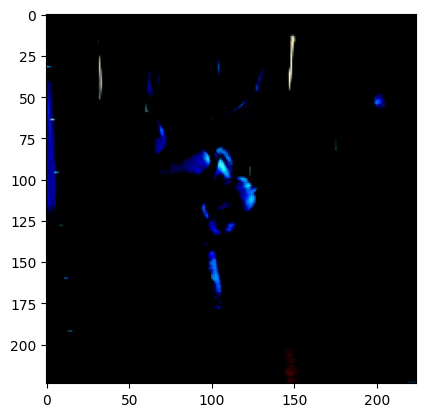

image_num: 8
orig_label: Person
labels: No Person


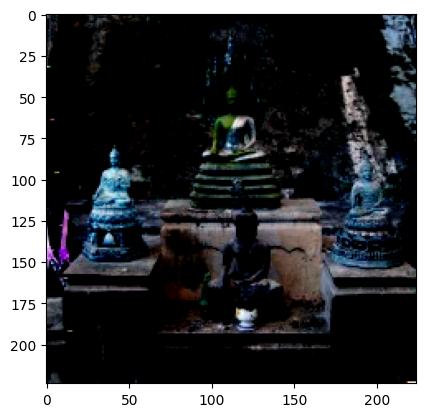

image_num: 33
orig_label: No Person
labels: Person


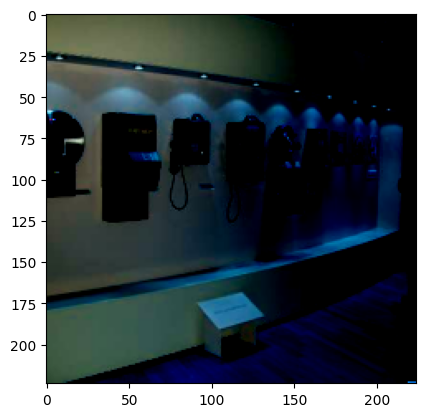

image_num: 40
orig_label: Person
labels: No Person


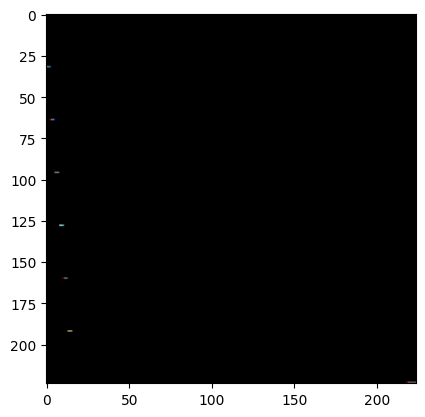

image_num: 51
orig_label: Person
labels: No Person


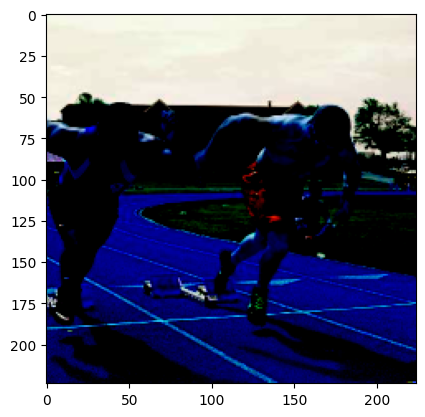

image_num: 53
orig_label: Person
labels: No Person


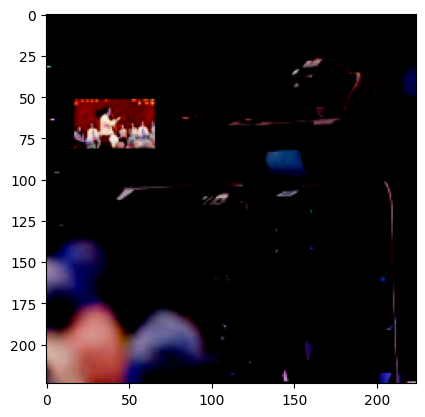

image_num: 99
orig_label: No Person
labels: Person


In [46]:
for i in incorrect_idx:
    plt.imshow(gen_items[i]['target'])
    plt.show()
    org_lbl = "Person" if gen_items[i]['metadata']['orig_label'] == 1 else "No Person"
    print("image_num:", i)
    print("orig_label:", org_lbl)
    print("labels:", df.iloc[i]['labels'])

In [15]:
for i, ds_entry in enumerate(test.take(100)):
    if str(ds_entry['image/filename'].numpy()) == "b'c33cf573a6d16e7d.jpg'":#"b'a82a8800cd9e7689.jpg'":
        test_ds_entry = ds_entry
        print("image found")



In [9]:
from experiment_config import default_cfg
def check_bbox_label(ds_entry, label_number, cfg=default_cfg):

    return_value = False  # This extra variable is needed as tensorflow does not allow return statements in loops.
    object_present_tensor = tf.equal(
        tf.constant(label_number, tf.int64), ds_entry["bobjects"]["label"]
    )
    bounding_boxes = ds_entry["bobjects"]["bbox"][object_present_tensor]

    #crop the bounding box area to the center crop that will happen in preprocessing.
    orig_image_h = tf.shape(ds_entry["image"])[0]
    orig_image_w = tf.shape(ds_entry["image"])[1]

    h, w = cfg.INPUT_SHAPE[0], cfg.INPUT_SHAPE[1]

    small_side = tf.minimum(orig_image_h, orig_image_w)
    scale =  h / small_side
    image_h = tf.cast(tf.cast(orig_image_h, tf.float64) * scale, tf.int32)
    image_w = tf.cast(tf.cast(orig_image_w, tf.float64) * scale, tf.int32)

    image_h = image_h if image_h > h else h
    image_w = image_w if image_w > w else w


    dy = (image_h - h) // 2
    dx = (image_w - w) // 2
    crop_x_min = tf.cast(dx / image_w, tf.float32)
    crop_x_max = tf.cast((dx + w) / image_w, tf.float32)
    crop_y_min = tf.cast(dy / image_h, tf.float32)
    crop_y_max = tf.cast((dy + h) / image_h, tf.float32)

    for bounding_box in bounding_boxes:
        # bbox is complete outside of crop
        if ((bounding_box[0] > crop_y_max) or 
            (bounding_box[2] < crop_y_min) or 
            (bounding_box[1] > crop_x_max) or 
            (bounding_box[3] < crop_x_min)):
            continue

        #orig pixel values of bounding box
        bb_y_min = tf.cast(bounding_box[0] * tf.cast(orig_image_h, tf.float32), tf.int32)
        bb_x_min = tf.cast(bounding_box[1] * tf.cast(orig_image_w, tf.float32), tf.int32)
        bb_y_max = tf.cast(bounding_box[2] * tf.cast(orig_image_h, tf.float32), tf.int32)
        bb_x_max = tf.cast(bounding_box[3] * tf.cast(orig_image_w, tf.float32), tf.int32)

        #rescale to new image size
        bb_y_min = (bb_y_min - dy) / h
        bb_x_min = (bb_x_min - dx) / w
        bb_y_max = (bb_y_max - dy) / h
        bb_x_max = (bb_x_max - dx) / w


        tmp_bb_y_min = bb_y_min if bounding_box[0] > crop_y_min else 0.0
        tmp_bb_y_max = bb_y_max if bounding_box[2] < crop_y_max else 1.0
        tmp_bb_x_min = bb_x_min if bounding_box[1] > crop_x_min else 0.0
        tmp_bb_x_max = bb_x_max if bounding_box[3] < crop_x_max else 1.0

        bb_effective_height = tmp_bb_y_max - tmp_bb_y_min
        bb_effective_width = tmp_bb_x_max - tmp_bb_x_min

        if (bb_effective_height * bb_effective_width) > cfg.MIN_BBOX_SIZE:
            return_value = True
    
    return return_value

In [10]:
check_bbox_label(test_ds_entry, 68)

True

In [1]:
import keras
from experiment_config import default_cfg as cfg

lr_schedule = keras.optimizers.schedules.CosineDecay(
        cfg.INIT_LR, decay_steps=cfg.DECAY_STEPS, alpha=0.0,
        warmup_target=cfg.LR, warmup_steps=cfg.WARMUP_STEPS
    )

Using TensorFlow backend


2023-12-19 22:00:36.599583: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 22:00:36.712439: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 22:00:36.712507: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 22:00:36.712577: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 22:00:36.731591: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 22:00:36.733486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

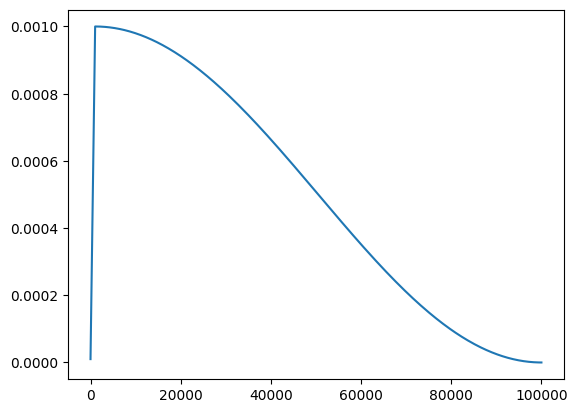

In [2]:
#plot the learning rate schedule
import matplotlib.pyplot as plt

lrs = []
for step in range(0, cfg.STEPS):
    lrs.append(lr_schedule(step))

plt.plot(lrs)

In [1]:
from wake_vision_loader import get_distance_eval
from experiment_config import get_cfg

wv_small_config = get_cfg("wv_small")
# wv_small_config.INPUT_SHAPE = (96, 96, 3)

distance_eval = get_distance_eval(cfg=wv_small_config)

2023-12-29 19:49:23.851792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
9547
3065
1230
30226

13842

In [2]:
import cv2
import tensorflow as tf
gen_items = [{"target": cv2.cvtColor(tf.image.convert_image_dtype(image[0], tf.uint8).numpy(), cv2.COLOR_RGB2BGR),
        "defaults":{"image": {"label": ["Person" if label.numpy()[0] == 1 else "No Person"]}},
        "metadata": {"orig_label": label.numpy()[0], "image_num": i},
      } for i, (image, label) in enumerate(distance_eval["no_person"].take(100))]

2023-12-28 21:38:29.111971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
import qsl
from IPython.display import display
import tensorflow as tf


labeler = qsl.MediaLabeler(items=gen_items,
  config={"image": [
    {
      "name": "label",
      "options": [{ "name": "Person" }, { "name": "No Person" }],
      "multiple": False
    }
  ]})
labeler.mode = "dark"

display(labeler)

MediaLabeler(buttons={'prev': False, 'next': True, 'save': True, 'config': True, 'delete': False, 'ignore': Tr…